<h1 style="text-align:center;">Waste Classification - CNN - Keras & Tensorflow <h1>

## @Author: Group 1 - AWT306

Lu Quoc Khai Ho - A00096112

In [204]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image

import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2


from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.optimizer.set_jit(True) # optimize keras trainning process

## Defining variables and reusable functions

In [205]:
# Define dataset folder
current_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir =  current_dir + "/dataset"

# Set the testing directory path for model prediction
testing_dir = current_dir + "/test"

In [206]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"Total images: {image_count}") # Count total images in dataset folder

Total images: 2390


### Visualize trainning result

In [207]:
def visualize_training_result():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Load data using a Keras utility

## Generate more dataset

This function is used to generate the images for the mall dataset which uses the same method with data augmentation and save data to each label folder

In [208]:
#generate images from existed dataset
def generate_dataset_image(dataset_path, number_images):
    print("Images are generating... ")
    datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    
    subfolders = glob.glob(f"{dataset_path}/*")
    
    labels = []
    
    for path in subfolders:
        label = path.split("/")[-1]
        files = glob.glob(f"{path}/*")
        j = 0
        for file in files:
            img = keras.utils.load_img(file)  # this is a PIL image
            x = keras.utils.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
            # the .flow() command below generates batches of randomly transformed images
            # and saves the results to the `preview/` directory
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=f'{dataset_path}/{label}', save_prefix=f'generated.{j}.{label}', save_format='jpeg'):
                i += 1
                if i > (number_images - 1): # generate 1 image 3 times
                    break  # otherwise the generator would loop indefinitely
            j += 1
        
    print("Images generating is completed!")


In [209]:
#generate_dataset_image(data_dir, 4)

In [210]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"total images: {image_count}")

total images: 2390


### Define some parameters for the loader:

In [211]:
batch_size = 32
img_height = 180
img_width = 180

In [212]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2390 files belonging to 4 classes.
Using 1912 files for training.


In [215]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2390 files belonging to 4 classes.
Using 478 files for validation.


In [216]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['glass', 'metal', 'paper', 'plastic']


## Visualize the data

Testing image that fit to the label in random 1 batch dataset

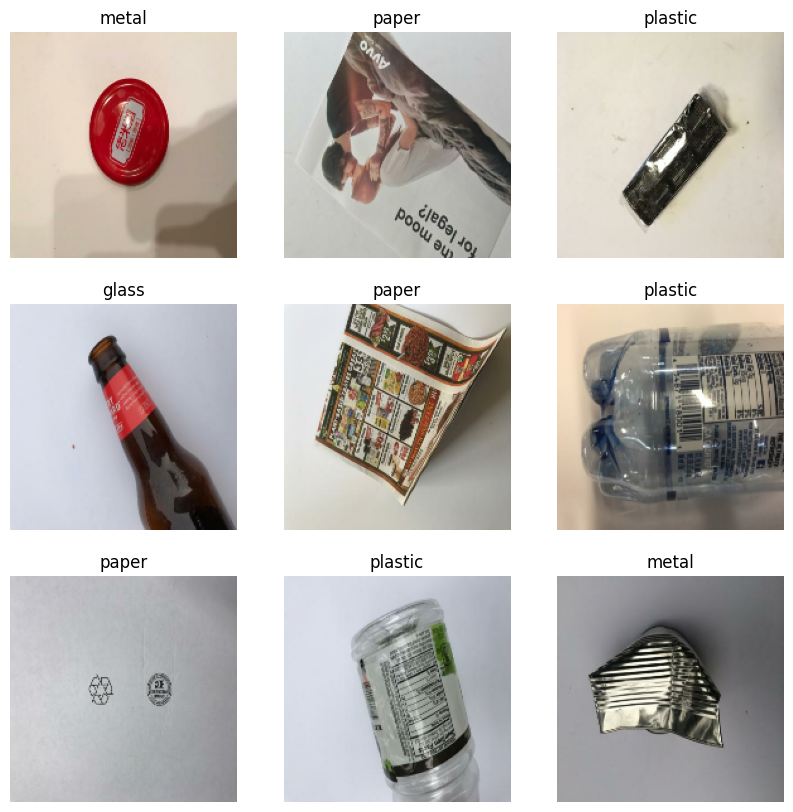

In [217]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [218]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [252]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Optimization for Training and Validation Datasets by caching and shuffling
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [253]:
# prefetching the training data to optimize pipeline
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [254]:
normalization_layer = layers.Rescaling(1./255)

In [255]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.24348602 0.94239306


# Overfitting Solutions

## 1. Data augmentation

In [256]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Apply data_augmentation to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

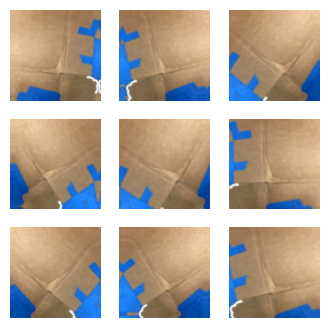

In [257]:
plt.figure(figsize=(4, 4))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [258]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [225]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [202]:
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_30 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_30 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,380 (8.09 MB)

 Trainable params: 2,121,380 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [203]:
epochs=50

early_stopping = keras.callbacks.EarlyStopping( monitor='val_loss',          
    mode='min',                   
    min_delta=0.01,              
    verbose=1,                    
    patience=10,                 
    restore_best_weights=True     
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - accuracy: 0.3382 - loss: 1.5404 - val_accuracy: 0.4184 - val_loss: 1.1955
Epoch 2/50
44/60 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4241 - loss: 1.2409

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (50,) and (38,)

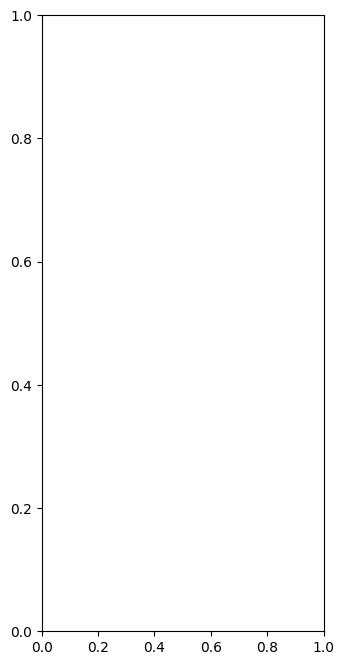

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 2. Combining Augmentation, Dropout, Early stopping

In [301]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


In [302]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    # optimizer=optimizer,
    optimizer='adam',
    # optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [303]:
model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_38 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_45 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [304]:
epochs = 50
early_stopping = keras.callbacks.EarlyStopping( monitor='val_loss',          
    mode='min',                   
    min_delta=0.001,              
    verbose=1,                    
    patience=10,                 
    restore_best_weights=True     
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 430ms/step - accuracy: 0.3775 - loss: 1.4692 - val_accuracy: 0.4937 - val_loss: 1.1490
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 415ms/step - accuracy: 0.4980 - loss: 1.1317 - val_accuracy: 0.5481 - val_loss: 1.0577
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 435ms/step - accuracy: 0.5622 - loss: 1.0458 - val_accuracy: 0.5649 - val_loss: 0.9851
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - accuracy: 0.5844 - loss: 0.9853 - val_accuracy: 0.5941 - val_loss: 0.9764
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 441ms/step - accuracy: 0.5907 - loss: 0.9645 - val_accuracy: 0.6088 - val_loss: 0.9140
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 476ms/step - accuracy: 0.6475 - loss: 0.8652 - val_accuracy: 0.6192 - val_loss: 0.9702
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 508ms/step - accuracy: 0.6665 - loss: 0.8365 - val_accuracy: 0.6381 - val_loss: 0.9813
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step - accuracy: 0.7057 - loss: 0.7666 - val_accu

## Visualize training results

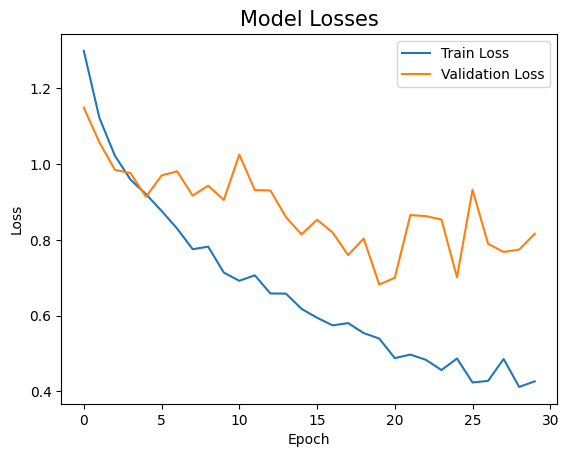

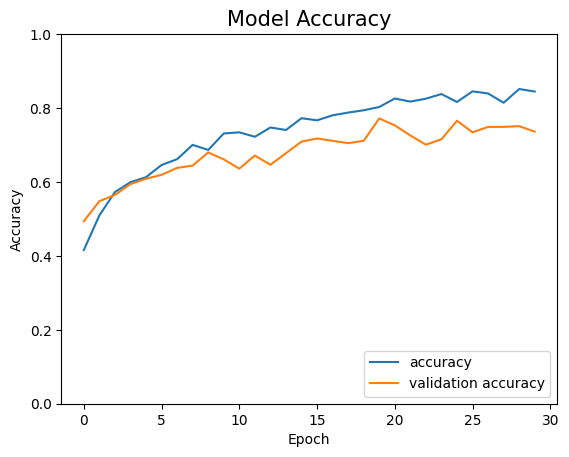

In [305]:
#Plotting train & validation loss
plt.figure()
plt.plot(history.history["loss"],label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Model Losses", size = 15)
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model Accuracy", size = 15)
plt.legend(loc='lower right')

plt.show()

## Save Keras model

In [306]:
model.save(f'{current_dir}/AWT306_Group1_CNN_Model.keras')

## Load Keras Model

In [307]:
group5_cnn_model = tf.keras.models.load_model(f'{current_dir}/AWT306_Group1_CNN_Model.keras')

# Show the model architecture
group5_cnn_model.summary()


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_38 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_45 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,967,470 (45.65 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,978,314 (30.43 MB)

## Predict on new data

In [308]:
import math
def resize_display_image(path, width):
    img = None
    if len(path):
        # Read the Image
        image = Image.open(path)
        ratio = (width/image.width)

        # Resize the image using resize() method
        image = image.resize((width, math.ceil(image.height * ratio)))
        
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
tf.Tensor([0.95327723 0.03474833 0.00523499 0.00673941], shape=(4,), dtype=float32)
['glass', 'metal', 'paper', 'plastic']
This image most likely belongs to glass with a 95.33 percent confidence.


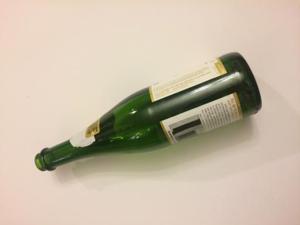

In [312]:
import random

animals = list(glob.glob(f'{testing_dir}/*'))

# Select a random item
#selected_item = random.choice(animals)
selected_item = testing_dir + '/glass_011.jpg'
img = tf.keras.utils.load_img(
    selected_item, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = group5_cnn_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(class_names)

# print(f"This image is {100 * (1 - score):.2f}% {class_names[np.argmax(score)]} and {100 * score:.2f}% dog.")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
# PIL.Image.open(str(selected_item))
resize_display_image(str(selected_item),300)